# Week 4: Homework 1 

----------------------------------------------------
Machine Learning                      

Year 2019/2020

*Vanessa Gómez Verdejo vanessa@tsc.uc3m.es* 

----------------------------------------------------

The goal of this practice is to analyze the performance of different estimators on the Diabetes problem and we will analyze, by means of different approximations, which input features are more relevant to solve this problem. 

Note that previous week we already worked on Diabetes database, but we only used one of the input variable (BMI) to construct the regression model; in this practice we will use all the input features jointly.

To solve these notebook, complete the following sections implementing the solution that you consider most appropriate and showing the results that you find most interesting. For the evaluation of this notebook,  we will take into account the methodology used, the solution adopted, the presentation of the results and the conclusions obtained at the light of the results.


## 1. Data loading and preprocessing

Following the ML pipeline, start loading the data, creating the partitions that you consider necessary and carrying out the preprocessing that yu need.

Keep in mind that there is no single valid solution, and different reasons can lead you to make different data partitions or apply different normalizations. So **please justify the steps you are taking**.

In [0]:
# Data loading and preprocessing

# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
# Load the diabetes dataset
diabetes = load_diabetes()
X = diabetes.data
Y = diabetes.target
feature_names = diabetes.feature_names

In [0]:
# Generate train and test partitions
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Data normalization
transformer = StandardScaler().fit(X_train)  # fit() learns mean and std parameters
X_train = transformer.transform(X_train) # transform() normalizes
X_test =  transformer.transform(X_test)

# Generate validation set
####
#### Let's better use GridSearchCV


## 2. Performance evaluation 

Now, analyze the performance of different estimators to predict the diabetes progression from all the available features. 

As possible estimators to be included in this study, we will consider those studied so far: K-NN, linear regressor, polynomial regressor and their regularized versions. Please, in case these methods have any free hiperparameter, **clearly justify** the selection of their optimal values.

As you know, for the performance evaluation, we have seen several metrics. So, here, you can use one or several of them. But, regardless of the used metric, don't forget to include a final analysis comparing the performance of different methods and trying to justify the obtained results.

In [0]:
## 2. Performance evaluation 

# Include your code here (create as many cells as you need)

### 2.1 K-NN
First of all, let's use the K-NN estimator in order to try to predict disease progression


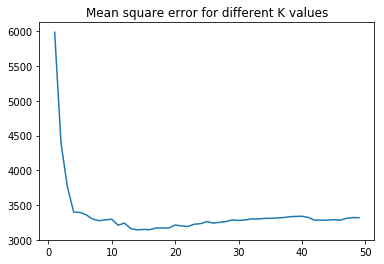

The optimal k value is 14


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=14, p=2,
                    weights='uniform')

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Create a KNN object from th SKlearn module
neigh = KNeighborsRegressor()  

# Perform a Cross-Validation in order to choose the hiperparameter K
rang_k = np.arange(1,50)
parameters = {'n_neighbors' : rang_k}
clf = GridSearchCV(neigh,parameters,iid=False,cv=10, scoring = 'neg_mean_squared_error')
clf.fit(X_train,Y_train) # this executes the cross-validation

# Visualize the results of CrossValidation
sqerrors_k = clf.cv_results_['mean_test_score']*-1
optimk = clf.best_params_['n_neighbors']
plt.figure()
plt.plot(rang_k, sqerrors_k)
plt.title('Mean square error for different K values')
plt.show()
print('The optimal k value is %d' %optimk)

# The KNN estimator, already trained with the optimal K
neigh = clf.best_estimator_
neigh.fit(X_train,Y_train) # and provide our data to the model

For evaluation of the method, R2 score is going to be used. It is the most used metric, as it is easy to interpret: 1.00 would mean no error; 0.00 would mean predicting always the mean, and negative would be performing even worse.

In [14]:
# Let's now evaluate the performance of the KNN regressor over the test data
from sklearn.metrics import r2_score


knn_prediction = neigh.predict(X_test)
knn_score = r2_score(Y_test,knn_prediction)
print('The R2 score of the KNN method is %.3f' %knn_score)

The R2 score of the KNN method is 0.329


### 2.2. Linear regressor

In [16]:
import sklearn.linear_model as ln

# Let's train several different linear regressors, and find their score

# Ordinary least squares linear regression
linear = ln.LinearRegression(fit_intercept=True).fit(X_train,Y_train)
linear_prediction = linear.predict(X_test)
linear_score = r2_score(Y_test,linear_prediction)
print('The R2 score of the linear regressor is %.3f' %linear_score)

# Lasso. Needed to cross-validate alpha
lasso = ln.Lasso()
rang_alpha = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
parameters = {'alpha' : rang_alpha}
clf = GridSearchCV(lasso,parameters,iid=False,cv=10, scoring= 'neg_mean_squared_error')
clf.train(X_train,Y_train)

The R2 score of the linear regressor is 0.332


### Regularized version

### 2.3. Polynomial regressor

### Regularized version

## 3. Study of feature relevance and feature selection

In this last section, using different criteria, you have to analyze the relevance of the input features. Thus, you will have to find a subset with the $D'$ most relevant features and, using this subset of features, analyze the final performance of a regressor (for the sake of simplicity, consider a linear ridge regressor as final regressor).

To analyze the feature importances or relevances, you can use the following criteria:

1. **Relevance ranking based on the validation error**: if there were $D$ input features, we could try to train $D$ regressors where each regressor uses one (and only one) different input feature. According to the final perfomance of each regressor (evaluated on a validation set or with a CV proccess), we could rank the features (the most relevant feature is the one providing the lowest error). Using this ranking, we can select the $D'$ most relevant features as the $D'$ top-ranked ones. Note that this scheme only analyzes the isolated relevance of each feature to predict the output; so, it is said that this approach is *univariate*.

 <img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Regression/FeatureRanking.png" width="90%" > 


2. **Greedy search based on the validation error**: approach (1) has the disadvantage of not taking into account relationships between features. For instance, method (1) would not realize that two features can be rendundant or that a feature, that is useless by itself, can be very useful combined with another feature. To overcome this drawback, we should have to analyze subsets of features; however, exploring all possible subsets  is usually computationally unflexible (there are $2^D$ combinations!!!!); so a greedy search (fordward or backward) is usually prefered:

  2.1 *Fordward search*: It starts with an empty set and, iteratively, adds new features according to a relevance criterion (in this case, minimum validation MSE).

  <img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Regression/Fig_Forward_search.png" width="48%" > 

  2.2 *Backward search*: It starts considering all the features and, iteratively, removes features according to a relevance criterion (in this case, minimum validation MSE).

  <img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Regression/Fig_Backward_search.png" width="48%" > 

3. **Ridge linear regression with a prunning**: We know that the L2 regularization limits the magnitude of the weight vector to avoid overfitting problems, but these weigths do not become to null. However, in a linear model, *the weight magnitude can be an indicative of the feature relevance* and, unlike approach (1), all features are analyzed at the same time (*multivariate approach*). Use the weigth magnitude to generate a ranking of features and, later, use this ranking to select the $D'$ most relevant features.

4. **Lasso linear regression**: In this case, the L1 penalty allows us to directly eliminate some of the input features. Explore different values of the regularization parameter $\lambda$ to get a sequence of selected feature sets (from a single feature to all features).


5. **Elastic-net linear regression**: This last approach combines L1 and L2 regularizations, thus including the advantages of both methods. Varying adequately their regularization parameters, create a sequence of feature selection subsets. 



Final comments:

* Due to part of the feature selection process involves selecting the optimum number of features, to avoid additional complexity (having to validate this number), you can analyze the different methods by exploring the curves of MSE vs. number of selected features ($D'$).

* It is not necessary to apply all these methods to complete this notebook (you can choose, at least, three of them). In fact, the implementation of greedy search approaches require an advanced knowledge of Python; so take this into account when you design your notebook solution.

* **Please, analyze in detail the different results, pointing out the advantages/disadvantages of each feature selection scheme**. Think about the behaviour of the different criteria in cases where a feature is irrelevant or there are redundant features. Additional experiments helping you to support any of your conclusions will be welcome.

In [0]:
## 3. Feature selection 

# Include your code here (create as many cells as you need)